In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML, display
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.api import OLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.metrics import r2_score
from pandas.plotting import scatter_matrix

# Text pipeline and NLP packages
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer

# Scikit Learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

from wordcloud import WordCloud

import tensorflow as tf
import tensorflow_hub as hub
from absl import logging

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Read in and basic overview

In [3]:
# Read csv dataset
path_dataset = 'gdrive/My Drive/CS109BProject/data/Capital_Projects.csv'
df = pd.read_csv(path_dataset)
#df = pd.read_csv('Capital_Projects.csv')
#print(df.shape)
df.replace('', np.nan, inplace=True)
# Drop nan values for the following columns
df = df.dropna(subset=['Budget Forecast', 'Total Budget Changes',
                       'Forecast Completion', 'Total Schedule Changes'], how='all')
# Only take budget forecast for positive values
df = df[df['Budget Forecast'] > 0]
# Reset index to eliminate completely missing rows from the dataframe
df.reset_index(drop=True, inplace=True)
# Keep only last row of each project
df = df.groupby('PID').tail(1)

# Minimize the effect of ZERO schedule change on regression model
new_df = df[df['Total Schedule Changes'] == 0].sample(n=15, random_state=1)
df = df[df['Total Schedule Changes'] != 0]
df = df.append(new_df)

# Minimize the effect of ZERO budget change on regression model
new_df = df[df['Total Budget Changes'] == 0].sample(n=7, random_state=1)
df = df[df['Total Budget Changes'] != 0]
df = df.append(new_df)
df.describe(include='all')

,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,Budget Forecast,Latest Budget Changes,Total Budget Changes,Forecast Completion,Latest Schedule Changes,Total Schedule Changes
count,301,301.000000,301,298,301,152,301,240,301,294,3.010000e+02,2.480000e+02,2.480000e+02,299,246.000000,246.000000
unique,4,NaN,301,277,21,19,12,29,5,256,NaN,NaN,NaN,252,NaN,NaN
top,09/01/2019 12:00:00 AM,NaN,Staten Island 1 & 3 Garage Construction & Rehab,Design and construction of a new school,Streets and Roadways,Brooklyn,DDC,DEP,Construction,05/04/2016,NaN,NaN,NaN,12/31/2019,NaN,NaN
freq,240,NaN,1,16,63,41,152,105,144,7,NaN,NaN,NaN,11,NaN,NaN
mean,NaN,639.368771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.128818e+08,2.684097e+06,2.010676e+07,NaN,66.967480,562.239837
std,NaN,274.070782,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.574745e+08,4.023569e+07,8.348361e+07,NaN,216.554972,657.996523
min,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.116642e+06,-2.664272e+08,-2.919002e+08,NaN,-995.000000,-1412.000000
25%,NaN,474.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.595827e+07,0.000000e+00,0.000000e+00,NaN,0.000000,86.500000
50%,NaN,656.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.501760e+07,0.000000e+00,4.953144e+06,NaN,0.000000,450.000000
75%,NaN,868.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.038300e+07,1.000000e+06,2.574161e+07,NaN,91.000000,944.250000


## NLP Embedding preparation

In [4]:
# Define list of stop words and a function to normalize text
nltk.download('stopwords')
stops = set(stopwords.words("english"))
stops = stops.union(['i','say','like','year','one','also','said','use'])

# Define tokenizer to split sentence into tokens
tokenizer = RegexpTokenizer(r'[a-z]+')

def textNormalize(text):
    textLower = text.lower()
    textList = tokenizer.tokenize(textLower)
    stopped_doc_tokens = [word for word in textList if not word in stops]
    stopstem_doc_tokens0 = [PorterStemmer().stem(word) for word in stopped_doc_tokens]
    stopstem_doc_tokens = [word for word in stopstem_doc_tokens0 if len(word)>1]
    return stopstem_doc_tokens

#example to check how it works
textNormalize(".. 120 I'm in Delhi India,,, today is 2019. went flying")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['delhi', 'india', 'today', 'went', 'fli']

In [5]:
df['Description'] = df['Description'].astype(str)
df['Normalized Description'] = df['Description'].apply(textNormalize)
df['normal_joined'] = df['Normalized Description'].apply(', '.join)
df['normal_joined'] = df['normal_joined'].apply(lambda x: x.replace(', ', ' '))
df.head(n=3)

,Date Reported As Of,PID,Project Name,Description,Category,Borough,Managing Agency,Client Agency,Current Phase,Design Start,Budget Forecast,Latest Budget Changes,Total Budget Changes,Forecast Completion,Latest Schedule Changes,Total Schedule Changes,Normalized Description,normal_joined
12,09/01/2019 12:00:00 AM,3,26th Ward Waste Water Treatment Plant Prelimin...,The 26th Ward WWTP is mandated to be upgraded ...,Wastewater Treatment,Brooklyn,DEP,DEP,Construction,09/23/2013,1.805777e+08,-4664980.0,-4318643.37,10/09/2020,0.0,270.0,"[th, ward, wwtp, mandat, upgrad, preliminari, ...",th ward wwtp mandat upgrad preliminari treatme...
27,09/01/2019 12:00:00 AM,7,Bowery Bay Waste Water Treatment Plant Main Se...,The existing Main Sewage Pumps have deteriorat...,Wastewater Treatment,Queens,DEP,DEP,Construction,05/01/2013,6.879846e+07,1065884.0,15305457.00,02/14/2020,88.0,685.0,"[exist, main, sewag, pump, deterior, pump, sys...",exist main sewag pump deterior pump system inc...
42,09/01/2019 12:00:00 AM,18,Croton Falls Pumping Station Construction,This project will construct a new pumping stat...,Water Supply,Carmel,DEP,DEP,Construction,08/22/2003,6.787161e+07,-1399611.0,1255175.02,03/10/2020,91.0,1014.0,"[project, construct, new, pump, station, repla...",project construct new pump station replac hydr...


In [6]:
# Universal sentence encoder 
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4" #@param ["https://tfhub.dev/google/universal-sentence-encoder/4", "https://tfhub.dev/google/universal-sentence-encoder-large/5"]
model = hub.load(module_url)
print ("module %s loaded" % module_url)
def embed(input):
  return model(input)

module https://tfhub.dev/google/universal-sentence-encoder/4 loaded


## Data Transformation, Feature Engineering and Plots

In [7]:
#### (1) #### CHANGE object to datetime64[ns] for columns with dates, drop NaNs
df['Forecast Completion'] =pd.to_datetime(df['Forecast Completion'], format='%m/%d/%Y', exact=False)
df['Date Reported As Of'] = pd.to_datetime(df['Date Reported As Of'],format='%m/%d/%Y', exact=False)
df['Design Start'] = pd.to_datetime(df['Design Start'], format='%m/%d/%Y', exact=False)
date_reported_min = min(df['Date Reported As Of'])
date_min = min([min(df['Date Reported As Of']), min(df['Design Start']), min(df['Forecast Completion'])])
print(f'Minimum Date: {date_min}')
print(f'Date Reported Minimum: {date_reported_min}')
df.dtypes

Minimum Date: 1993-08-02 00:00:00
Date Reported Minimum: 2018-08-01 00:00:00


Date Reported As Of        datetime64[ns]
PID                                 int64
Project Name                       object
Description                        object
Category                           object
Borough                            object
Managing Agency                    object
Client Agency                      object
Current Phase                      object
Design Start               datetime64[ns]
Budget Forecast                   float64
Latest Budget Changes             float64
Total Budget Changes              float64
Forecast Completion        datetime64[ns]
Latest Schedule Changes           float64
Total Schedule Changes            float64
Normalized Description             object
normal_joined                      object
dtype: object

In [8]:
### (a) Schedule Change Norm ===>  Change Normalized to Project Duration of each project
df['Project Duration'] = df['Forecast Completion'] - df['Design Start']
df['Schedule Change Norm'] = df['Total Schedule Changes']/(df['Project Duration']/pd.Timedelta(days=1))

### (b) Project Duration Norm ===> Normalized over all projects (to normalize across big and small projects)
max_project_duration = max(df['Project Duration'])
min_project_duration = min(df['Project Duration'])
#df['Project Duration Norm'] = (df['Project Duration'] - min_project_duration) / (max_project_duration - min_project_duration)
df['Project Duration'] = df['Project Duration']/pd.Timedelta(days=1)
print(f'Max Project Duration: {max_project_duration} \nMin Project Duration: {min_project_duration} ')
df.describe()

Max Project Duration: 9736 days 00:00:00 
Min Project Duration: 656 days 00:00:00 


,PID,Budget Forecast,Latest Budget Changes,Total Budget Changes,Latest Schedule Changes,Total Schedule Changes,Project Duration,Schedule Change Norm
count,301.000000,3.010000e+02,2.480000e+02,2.480000e+02,246.000000,246.000000,293.000000,241.000000
mean,639.368771,1.128818e+08,2.684097e+06,2.010676e+07,66.967480,562.239837,2773.535836,0.180054
std,274.070782,2.574745e+08,4.023569e+07,8.348361e+07,216.554972,657.996523,1418.030371,0.218157
min,3.000000,2.116642e+06,-2.664272e+08,-2.919002e+08,-995.000000,-1412.000000,656.000000,-0.722620
25%,474.000000,3.595827e+07,0.000000e+00,0.000000e+00,0.000000,86.500000,1879.000000,0.037037
50%,656.000000,5.501760e+07,0.000000e+00,4.953144e+06,0.000000,450.000000,2429.000000,0.167430
75%,868.000000,9.038300e+07,1.000000e+06,2.574161e+07,91.000000,944.250000,3171.000000,0.310505
max,1014.000000,2.449622e+09,5.322707e+08,8.078026e+08,1413.000000,3253.000000,9736.000000,1.023743


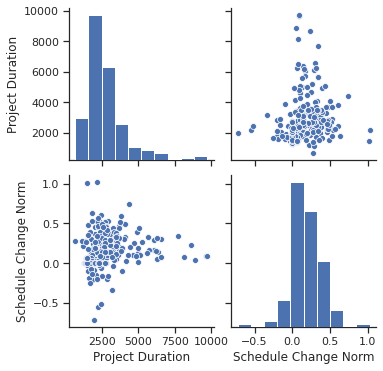

In [9]:
import seaborn as sns
sns.set(style="ticks")
sns.pairplot(df[['Project Duration', 'Schedule Change Norm']])

In [10]:
### (a) Budget Change Norm ===>  Budget Change Normalized to Final Budget of each project
df['Budget Change Norm'] = df['Total Budget Changes']/df['Budget Forecast']

### (b) Total Budget Norm ===> Budget Forecast Normalized through all projects
max_budget_final = max(df['Budget Forecast'])
min_budget_final = min(df['Budget Forecast'])
df['Total Budget Norm'] = (0.9 - 0.1)*(df['Budget Forecast'] - min_budget_final)/(max_budget_final - min_budget_final) + 0.1
print(f'Max Budget: {max_budget_final} \n Min Budget: {min_budget_final}')


Max Budget: 2449621616.0 
 Min Budget: 2116642.0


### Remove Outliers

In [11]:
# Remove outliers
df = df[df['Budget Change Norm'] > -2]
df = df[df['Total Budget Norm'] < 0.3]
min_budget_norm = min(df['Budget Change Norm'])
print(f'Minimum Budget Change Norm: {min_budget_norm}')
df.describe()

Minimum Budget Change Norm: -1.9474624118003965


,PID,Budget Forecast,Latest Budget Changes,Total Budget Changes,Latest Schedule Changes,Total Schedule Changes,Project Duration,Schedule Change Norm,Budget Change Norm,Total Budget Norm
count,235.000000,2.350000e+02,2.350000e+02,2.350000e+02,233.000000,233.000000,230.000000,230.000000,235.000000,235.000000
mean,564.587234,8.243385e+07,1.707614e+06,1.511469e+07,65.296137,548.008584,2872.856522,0.177726,0.137055,0.126253
std,247.255975,7.753500e+07,1.141958e+07,3.633377e+07,201.971731,652.755023,1440.048335,0.218598,0.365015,0.025343
min,3.000000,1.008834e+07,-6.467696e+07,-1.743460e+08,-995.000000,-1412.000000,656.000000,-0.722620,-1.947462,0.102606
25%,431.500000,3.933650e+07,0.000000e+00,0.000000e+00,0.000000,77.000000,1981.250000,0.033659,0.000000,0.112166
50%,588.000000,5.943100e+07,0.000000e+00,4.615000e+06,0.000000,436.000000,2486.000000,0.164496,0.089425,0.118734
75%,761.500000,9.693639e+07,9.704995e+05,2.537455e+07,91.000000,939.000000,3321.250000,0.307498,0.326867,0.130993
max,960.000000,6.137973e+08,7.255500e+07,1.709440e+08,1413.000000,3253.000000,9736.000000,1.023743,1.000000,0.299936


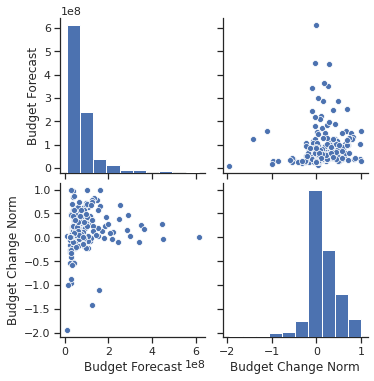

In [12]:
sns.set(style="ticks")
sns.pairplot(df[['Budget Forecast', 'Budget Change Norm']])

### Adding NLP embedded columns and running PCA to limit # of columns

In [13]:
# The embedding of the description is ready for use in Regression later
embedding = embed(df.normal_joined).numpy()
df_embed = pd.DataFrame(embedding)
from sklearn.decomposition import PCA
pca = PCA(n_components=45)
pc = pca.fit_transform(df_embed)
print(np.sum(pca.explained_variance_ratio_))#percent of variance explained by the the # pc axes chosen
df_pc = pd.DataFrame(pc)
# concatenate the columns related to embedding of project description (512 columns)
df = df.reset_index(drop=True).merge(df_pc.reset_index(drop=True), left_index=True, right_index=True)

0.7668899


### Adding Dummy variables and dropping categorical columns

In [0]:
####  (4)  #### Handle Categorical Columns using dummy variables
categorical_columns = ['Category', 'Borough'] # not including Agencies nor Decription
nyc_df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

#### (5) #### Drop redundant or useless columns, and drop NaNs
drop_columns = ['Date Reported As Of', 'PID', 'Project Name', 'Description','Managing Agency', 
                'Client Agency', 'Design Start', 'Total Budget Norm', 'Latest Budget Changes', 
                'Latest Schedule Changes', 'Total Schedule Changes', 'Total Budget Changes', 
                'Forecast Completion', 'Current Phase']
nyc_df = nyc_df.drop(drop_columns, axis=1, errors='ignore')

##### TRANSFORMATION

In [15]:
# TRANSFORMATION
# Log of both Project Duration and Budget Forecast
nyc_df['Budget Forecast'] = np.log(nyc_df['Budget Forecast'])
nyc_df['Project Duration'] = np.log(nyc_df['Project Duration'])
nyc_df.describe()

,Budget Forecast,Project Duration,Schedule Change Norm,Budget Change Norm,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,...,40,41,42,43,44,Category_Bridges,"Category_Bridges, Streets and Roadways",Category_Ferries,Category_Health and Hospitals,"Category_Health and Hospitals, IT",Category_IT,Category_Industrial Development,"Category_Industrial Development, Streets and Roadways",Category_Libraries,Category_Other Government Facilities,Category_Parks,Category_Public Safety and Criminal Justice,Category_Sanitation,Category_Schools,Category_Sewers,Category_Streets and Roadways,Category_Wastewater Treatment,Category_Water Supply,"Borough_Bronx, Manhattan",Borough_Brooklyn,"Borough_Brooklyn, Queens",Borough_Carmel,Borough_Citywide,Borough_Manhattan,"Borough_Manhattan, Bronx","Borough_Manhattan, Staten Island","Borough_Manhattan, Staten Island, Bronx",Borough_Manhatten,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla
count,235.000000,230.000000,230.000000,235.000000,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,...,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,2.350000e+02,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,17.963800,7.867122,0.177726,0.137055,1.116002e-08,-1.791310e-08,1.038326e-09,5.960465e-09,-1.077956e-09,-2.710743e-09,-6.721375e-09,3.646029e-09,-9.749164e-09,7.070125e-09,8.243196e-10,-8.972401e-09,-1.521821e-09,8.243195e-09,1.327234e-08,1.391832e-08,-2.869266e-09,1.031985e-08,5.960465e-09,6.975012e-10,-1.395002e-09,9.511379e-09,-5.136145e-09,2.472959e-09,1.838867e-09,4.311826e-09,8.591946e-09,9.511379e-10,-2.029094e-09,-6.784784e-09,4.787394e-09,-1.705707e-08,-6.340919e-10,-1.537673e-09,8.150064e-09,5.738532e-09,...,9.828425e-09,-1.109661e-09,4.502053e-09,-2.029094e-09,2.506645e-09,0.080851,0.059574,0.017021,0.017021,0.004255,0.008511,0.114894,0.004255,0.008511,0.042553,0.012766,0.046809,0.017021,0.051064,0.127660,0.187234,0.093617,0.093617,0.004255,0.165957,0.004255,0.004255,0.029787,0.085106,0.008511,0.004255,0.004255,0.004255,0.004255,0.004255,0.004255,0.127660,0.046809,0.008511,0.004255
std,0.679063,0.421443,0.218598,0.365015,2.761015e-01,2.413457e-01,1.961732e-01,1.836039e-01,1.678684e-01,1.520525e-01,1.356464e-01,1.337044e-01,1.249338e-01,1.230373e-01,1.194625e-01,1.142709e-01,1.127882e-01,1.102036e-01,1.062301e-01,1.050817e-01,1.043037e-01,1.004729e-01,9.812086e-02,9.797547e-02,9.449751e-02,9.193463e-02,9.068528e-02,8.814762e-02,8.690502e-02,8.618727e-02,8.527096e-02,8.366883e-02,8.244216e-02,8.174249e-02,7.954931e-02,7.903121e-02,7.756539e-02,7.744342e-02,7.562320e-02,7.492258e-02,...,6.863185e-02,6.755149e-02,6.652090e-02,6.591658e-02,6.450538e-02,0.273188,0.237202,0.129627,0.129627,0.065233,0.092056,0.319574,0.065233,0.092056,0.202278,0.112503,0.211679,0.129627,0.220598,0.334423,0.390932,0.291917,0.291917,0.065233,0.372837,0.065233,0.065233,0.170363,0.279636,0.092056,0.065233,0.065233,0.065233,0.065233,0.065233,0.065233,0.334423,0.211679,0.092056,0.065233
min,16.126891,6.486161,-0.722620,-1.947462,-4.745959e-01,-4.947551e-01,-4.153628e-01,-4.332128e-01,-4.360163e-01,-4.361112e-01,-4.237539e-01,-2.942566e-01,-3.764822e-01,-3.364834e

### Test Train Split

In [0]:
nyc_df = nyc_df.dropna()
np.random.seed(49)
nyc_train, nyc_test = train_test_split(nyc_df, test_size=.1, random_state=49)

In [17]:
nyc_train.head()

,Budget Forecast,Normalized Description,normal_joined,Project Duration,Schedule Change Norm,Budget Change Norm,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,...,40,41,42,43,44,Category_Bridges,"Category_Bridges, Streets and Roadways",Category_Ferries,Category_Health and Hospitals,"Category_Health and Hospitals, IT",Category_IT,Category_Industrial Development,"Category_Industrial Development, Streets and Roadways",Category_Libraries,Category_Other Government Facilities,Category_Parks,Category_Public Safety and Criminal Justice,Category_Sanitation,Category_Schools,Category_Sewers,Category_Streets and Roadways,Category_Wastewater Treatment,Category_Water Supply,"Borough_Bronx, Manhattan",Borough_Brooklyn,"Borough_Brooklyn, Queens",Borough_Carmel,Borough_Citywide,Borough_Manhattan,"Borough_Manhattan, Bronx","Borough_Manhattan, Staten Island","Borough_Manhattan, Staten Island, Bronx",Borough_Manhatten,Borough_New York,Borough_Olive,Borough_Port Jervis,Borough_Queens,Borough_Staten Island,Borough_Upstate,Borough_Valhalla
131,18.118656,"[renov, floor, build, creat, new, offic, space...",renov floor build creat new offic space landma...,7.991592,0.294993,0.573541,0.378295,-0.138518,-0.107179,-0.052666,0.212179,-0.029425,0.080228,-0.158592,0.060520,-0.016534,0.114407,0.090035,0.038433,-0.108924,0.097535,0.216055,0.042823,-0.087408,0.104099,-0.089360,0.075654,-0.086334,-0.051737,0.018372,-0.081884,-0.065467,0.247719,0.062288,-0.150969,0.065288,-0.114291,-0.089389,0.127831,0.097969,...,-0.018494,-0.097264,-0.020028,-0.027240,0.037760,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
234,17.087662,"[new, utrech, branch, librari, comprehens, int...",new utrech branch librari comprehens interior ...,7.728856,0.007039,0.000000,0.346320,-0.120318,-0.029082,-0.119589,0.172437,-0.045494,0.219694,-0.070725,0.030790,-0.052350,0.102088,-0.038123,-0.174224,0.331454,0.001674,0.123206,-0.041677,-0.037863,0.144920,-0.140915,-0.025248,-0.219848,-0.037928,-0.002013,-0.117609,-0.032614,-0.009135,-0.040933,-0.080871,0.046072,0.060847,-0.116449,-0.121327,-0.024769,...,0.145007,0.058284,-0.204900,0.071676,-0.004871,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67,17.482732,"[distribut, water, main, replac, long, island,...",distribut water main replac long island citi a...,7.991254,0.276142,0.581585,-0.186727,0.108182,0.173701,0.197080,0.190838,0.157894,0.118657,0.026577,-0.177522,-0.070915,-0.060074,-0.010110,0.065824,-0.101002,0.064525,-0.090041,0.123619,0.219710,0.017467,0.143979,0.026965,-0.053517,-0.055505,-0.074393,-0.123195,0.100668,-0.052215,-0.025007,-0.029333,0.015154,0.007648,-0.130915,0.005436,0.068889,...,0.033694,-0.055822,0.020912,-0.014373,0.071342,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
96,18.621133,"[emerg, contract, restor, electr, mechan, syst...",emerg contract restor electr mechan system mov...,7.784889,0.298253,-0.023311,0.262254,-0.007902,-0.110770,0.423873,-0.208016,0.046922,-0.058156,0.049569,0.166270,0.138358,-0.203045,-0.064080,0.067257,0.057418,-0.070334,0.007495,-0.133226,0.124811,-0.079114,0.086103,0.029628,-0.041564,-0.052203,0.143644,-0.004361,0.089532,0.136742,-0.062903,0.046996,0.326217,-0.077786,-0.084925,0.074516,-0.022623,...,0.026692,-0.114641,0.010866,0.050081,0.047479,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
156,18.629166,"[design, construct, new, ferri, land, ferri, l...",design construct new ferri land ferri land upg...,7.820841,0.488764,0.371251,0.335519,-0.023814,0.125511,-0.061714,0.368217,0.107431,-0.057539,0.003363,0.017352,-0.049090,0.023153,0.051622,0.206468,-0.040998,0.142817,0.078650,-0.002368,-0.056208,-0.062475,0.026736,-0.022548,-0.003291,-0.074457,0.005905,-0.051095,0.072601,0.009317,0.058549,-0.146582,-0.020310,0.201538,0.024799,0.011594,-0.024003,...,-0.144543,-0.147914,-0.002381,0.084749,0.000509,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0

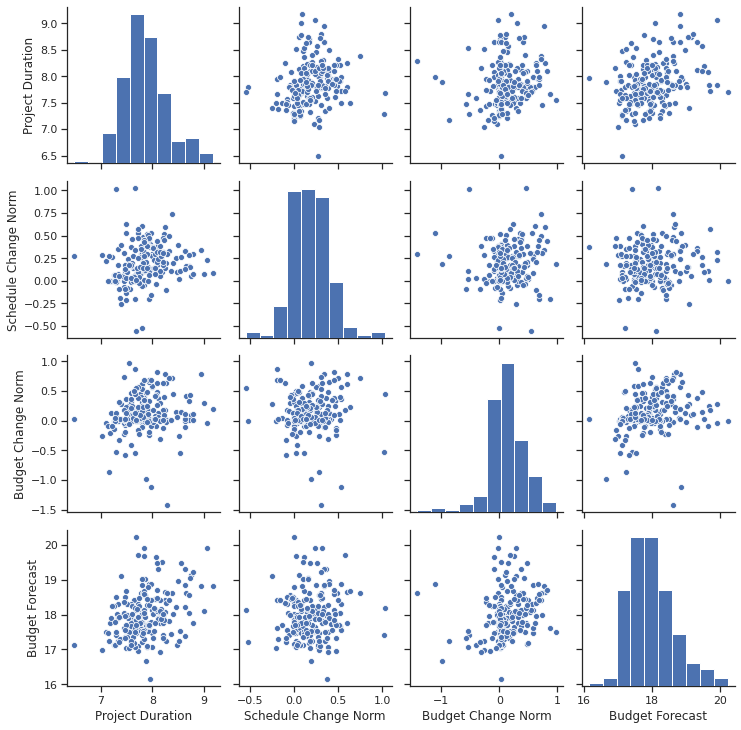

In [18]:
qual_columns = ['Project Duration',	'Schedule Change Norm',
                'Budget Change Norm',	'Budget Forecast']	
#scatter_matrix(nyc_train[qual_columns].sample(frac=0.4, axis=0),alpha=0.5, figsize=(25,20));
plt_df = nyc_train.copy()
sns.set(style="ticks")
sns.pairplot(plt_df[qual_columns])

In [19]:
nyc_train[qual_columns].corr()

,Project Duration,Schedule Change Norm,Budget Change Norm,Budget Forecast
Project Duration,1.000000,0.199344,0.130919,0.359923
Schedule Change Norm,0.199344,1.000000,0.052088,0.088461
Budget Change Norm,0.130919,0.052088,1.000000,0.230264
Budget Forecast,0.359923,0.088461,0.230264,1.000000


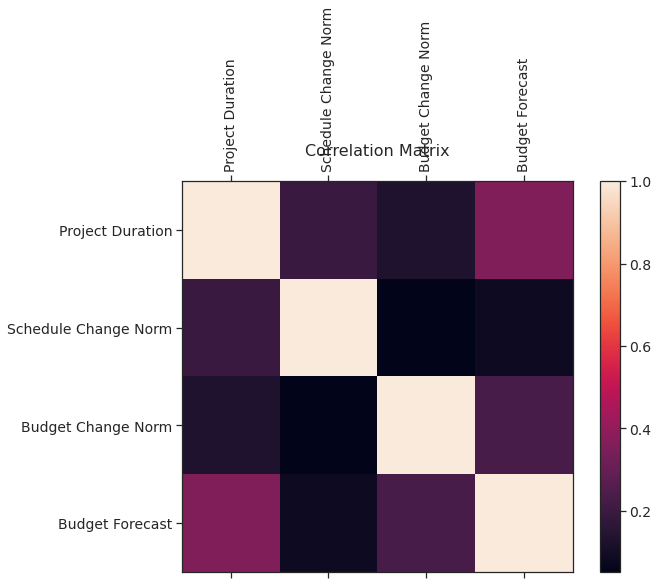

In [20]:
f = plt.figure(figsize=(10, 7))
plt.matshow(nyc_train[qual_columns].corr(), fignum=f.number)
plt.xticks(range(len(qual_columns)), qual_columns, fontsize=14, rotation=90)
plt.yticks(range(len(qual_columns)), qual_columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

### Regression - Linear Regression, Lasso and Ridge

---



#### Budget Change Model

##### Training and Test Data

In [0]:
# Y = "Budget Change Norm"
# X = "Schedule Change Norm" and "Budget Forecast"
#      Dropped "Project Duration" from X because of its multi-collinearity with 
#      "Budget Forecast" - determined by VIF

nyc_train_trunc = nyc_train.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_train = (nyc_train_trunc['Budget Change Norm'])
X_train = nyc_train_trunc.drop(['Budget Change Norm', 'Project Duration'], axis=1)

# Remove redundant columns: found through VIF (multi-collinearity analysis)
drop_mc_columns = ['Category_Health and Hospitals, IT', 'Category_IT', 'Category_Industrial Development, Parks',
                   'Category_Industrial Development, Streets and Roadways', 'Category_Libraries', 
                   'Borough_Brooklyn, Queens','Borough_Manhattan, Staten Island, Bronx', 'Borough_Olive',
                   'Borough_Marlboro', 'Borough_Port Jervis', 'Borough_New York', 
                   'Borough_Carmel','Category_Streets and Roadways', 
                   'Normalized Description', 'normal_joined']
X_train = X_train.drop(drop_mc_columns, axis=1, errors='ignore')

# Test Data
nyc_test_trunc = nyc_test.copy()
#nyc_test_trunc = nyc_test_trunc[qual_columns]
y_test = nyc_test_trunc['Budget Change Norm']
X_test = nyc_test_trunc.drop(['Budget Change Norm', 'Project Duration'], axis=1)
X_test = X_test.drop(drop_mc_columns, axis=1, errors='ignore')

# No need for polynomial interactions - doesn't improve test/training score
# Overfitting - not enough data
#--- poly = PolynomialFeatures(interaction_only=True,include_bias = False)
#--- X_train = poly.fit_transform(X_train)

# No need for increasing polynomial terms - decreases the test scores
# Overfitting - not enough data
#--- X_train['Budget_2T'] = X_train['Budget Forecast'] * X_train['Budget Forecast']
#--- X_train['Budget_3T'] = X_train['Schedule Change Norm'] * X_train['Budget Forecast']
#--- X_train['Project_2T'] = X_train['Project Duration'] * X_train['Project Duration']

##### Linear Regression and RidgeCV

In [22]:
np.random.seed(49)
lr_cost_model = LinearRegression().fit(X_train, y_train)
lr_cost_model.score(X_train, y_train)
alphas = (0.1, 0.5,1,5,10,50,100)
ridge_cost_model = RidgeCV(alphas=alphas, cv=20).fit(X_train, y_train)
lasso_cost_model = LassoCV(alphas=alphas, max_iter=100000).fit(X_train, y_train)

print(f'LinearRegression training score: {lr_cost_model.score(X_train, y_train)}')
print(f'Lasso training score: {lasso_cost_model.score(X_train, y_train)}')
print(f'Ridge training score: {ridge_cost_model.score(X_train, y_train)}')

LinearRegression training score: 0.4888744857475283
Lasso training score: 0.0
Ridge training score: 0.19753573591005158


In [23]:
testr2 = lr_cost_model.score(X_test, y_test)
print(f'LinearRegression test score: {lr_cost_model.score(X_test, y_test)}')
print(f'Lasso test score: {lasso_cost_model.score(X_test, y_test)}')
print(f'Ridge test score: {ridge_cost_model.score(X_test, y_test)}')

LinearRegression test score: 0.31334906504294424
Lasso test score: -0.0028014606265251984
Ridge test score: 0.21862749000322534


In [24]:
print(f'The best test r-squared value so far is {testr2}')

The best test r-squared value so far is 0.31334906504294424


### Bagging Techniques

In [25]:
# BAGGING TECHNIQUES
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
num_bags = 10
np.random.seed(49)
bagging_train = np.zeros((X_train.shape[0], num_bags))
bagging_test = np.zeros((X_test.shape[0], num_bags))
bagging_models = []
for i in range(num_bags):
  bootstrapped_X, bootstrapped_y = resample(X_train, y_train)
  fitted_model = RidgeCV(alphas=alphas,normalize=True, cv=5).fit(bootstrapped_X, bootstrapped_y)
  bagging_models.append(fitted_model)
  bagging_train[:,i] = fitted_model.predict(X_train)
  bagging_test[:,i] = fitted_model.predict(X_test)

bagging_train_predicts = np.mean(bagging_train[:,:], axis=1)
bagging_test_predicts = np.mean(bagging_test[:,:], axis=1)
print(f'Training score: {mean_squared_error(y_train, bagging_train_predicts)}')
print(f'Test score: {mean_squared_error(y_test, bagging_test_predicts)}')

Training score: 0.06668358495638112
Test score: 0.23694169520851097


In [26]:
X_train_ols = sm.add_constant(X_train)
results = OLS(y_train, X_train_ols).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Budget Change Norm   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.220
Method:                 Least Squares   F-statistic:                     1.819
Date:                Fri, 08 May 2020   Prob (F-statistic):            0.00149
Time:                        19:24:45   Log-Likelihood:                 11.770
No. Observations:                 207   AIC:                             120.5
Df Residuals:                     135   BIC:                             360.4
Df Model:                          71                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                          -1.8874      0.723     -2.611      0.010      -3.317      -0.458
Budget Forecast                                 0.1120      0.041      2.762      0.007       0.032       0.192
Schedule Change Norm                            0.1114      0.122      0.910      0.364      -0.131       0.353
0                                               0.0624      0.212      0.295      0.769      -0.356       0.481
1                                               0.2786      0.214      1.305      0.194      -0.144       0.701
2                                               0.2510      0.207      1.215      0.227      -0.158       0.659
3                                              -0.3897      0.217     -1.792      0.075      -0.820       0.040
4                                              -0.4180      0.163     -2.571      0.011      -0.740      -0.097
5                                              -0.0147      0.194     -0.076      0.939      -0.397       0.368
6                                               0.0608      0.191      0.318      0.751      -0.317       0.438
7                                               0.0656      0.187      0.351      0.726      -0.304       0.435
8                                              -0.6716      0.202     -3.327      0.001      -1.071      -0.272
9                                              -0.2648      0.202     -1.312      0.192      -0.664       0.134
10                                              0.0294      0.211      0.139      0.889      -0.388       0.447
11                                             -0.2900      0.247     -1.175      0.242      -0.778       0.198
12                                             -0.1008      0.218     -0.463      0.644      -0.532       0.330
13                                             -0.5025      0.245     -2.048      0.042      -0.988      -0.017
14                                              0.2607      0.244      1.068      0.288      -0.222       0.744
15                                             -0.1538      0.225     -0.684      0.495      -0.599       0.291
16                                             -0.1105      0.243     -0.455      0.650      -0.591       0.370
17                                             -0.2832      0.243     -1.166      0.246      -0.764       0.197
18                                              0.1993      0.228      0.873      0.384      -0.252       0.651
19                                             -0.0749      0.230     -0.326      0.745      -0.530       0.380
20                                              0.2917      0.262      1.114      0.267      -0.226       0.809
21                                              0.1448     

In [27]:
# Multi-collinearity
X_train_save = X_train.copy()
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.Series([variance_inflation_factor(X_train.values, i) 
               for i in range(X_train.shape[1])], 
               index=X_train.columns)

Budget Forecast          12.990474
Schedule Change Norm      3.065574
0                         8.213193
1                         6.592799
2                         4.342720
                           ...    
Borough_Manhatten         1.360607
Borough_Queens            1.822443
Borough_Staten Island     1.744894
Borough_Upstate           1.971808
Borough_Valhalla          1.693857
Length: 71, dtype: float64

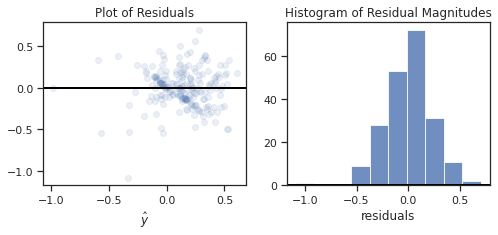

In [28]:
# Residual Plots
y_hat_train = results.predict()
residuals = (y_train - y_hat_train)
fig, axes = plt.subplots(1,2,figsize=(8,3))
axes[0].set_title('Plot of Residuals')
axes[0].scatter((y_hat_train), residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')
axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()


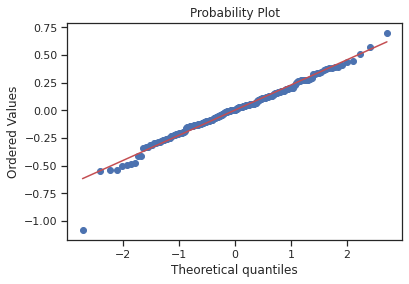

In [29]:
import pylab 
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

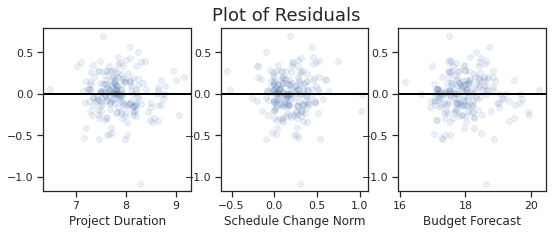

In [30]:
# Residual Plots
X_colms = ['Project Duration','Schedule Change Norm','Budget Forecast']
y_hat_train = results.predict()
residuals = y_train - y_hat_train

fig, axes = plt.subplots(1,3,figsize=(9,3))
fig.suptitle('Plot of Residuals', fontsize=18)
for i in range(3):
  x_val = y_hat_train
  x_lbl = r'$\hat{y}$'
  if i > -1:
    x_val = nyc_train[X_colms[i]].ravel()
    x_lbl = X_colms[i]
  row_idx = np.mod(i,3)
  col_idx = int(i / 3) 
  axes[row_idx].scatter(x_val, residuals, alpha=0.1)
  axes[row_idx].axhline(0, c='black', lw=2)
  axes[row_idx].set_xlabel(x_lbl, fontsize=12)
plt.show()

#### Schedule Change Model

##### Training and Test Data

In [0]:
# Schedule change
nyc_train_trunc2 = nyc_train.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_train2 = (nyc_train_trunc2['Schedule Change Norm'])
X_train2 = nyc_train_trunc2.drop(['Schedule Change Norm', 'Budget Forecast'], axis=1)
# Remove redundant columns: found through VIF (multi-collinearity analysis in below cell)
X_train2 = X_train2.drop(drop_mc_columns, axis=1, errors='ignore')

nyc_test_trunc2 = nyc_test.copy()
y_test2 = nyc_test_trunc2['Schedule Change Norm']
X_test2 = nyc_test_trunc2.drop(['Schedule Change Norm', 'Budget Forecast'], axis=1)
X_test2 = X_test2.drop(drop_mc_columns, axis=1, errors='ignore')

##### Linear Regression, LassoCV and RidgeCV

In [32]:
np.random.seed(49)
lr_time_model = LinearRegression().fit(X_train2, y_train2)
ridge_time_model = RidgeCV(alphas=alphas, cv=20).fit(X_train2, y_train2)
lasso_time_model = LassoCV(alphas=alphas, max_iter=100000).fit(X_train2, y_train2)

print(f'LinearRegression train score: {lr_time_model.score(X_train2, y_train2)}')
print(f'Lasso train score: {lasso_time_model.score(X_train2, y_train2)}')
print(f'Ridge train score: {ridge_time_model.score(X_train2, y_train2)}')

LinearRegression train score: 0.4297508291922434
Lasso train score: 0.0
Ridge train score: 0.268129939405938


In [33]:
print(f'LinearRegression test score: {lr_time_model.score(X_test2, y_test2)}')
print(f'Lasso test score: {lasso_time_model.score(X_test2, y_test2)}')
print(f'Ridge test score: {ridge_time_model.score(X_test2, y_test2)}')

LinearRegression test score: 0.167576360816865
Lasso test score: -0.09056901439333886
Ridge test score: 0.01378467219838031


In [34]:
# Multi-collinearity
X_train2_save = X_train2.copy()
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.Series([variance_inflation_factor(X_train2.values, i) 
               for i in range(X_train2.shape[1])], 
               index=X_train2.columns)

Project Duration         12.242651
Budget Change Norm        2.160408
0                         8.355191
1                         6.694722
2                         4.348197
                           ...    
Borough_Manhatten         1.369256
Borough_Queens            1.756265
Borough_Staten Island     1.715971
Borough_Upstate           2.011905
Borough_Valhalla          1.782407
Length: 71, dtype: float64

In [35]:
X_train2_ols = sm.add_constant(X_train2)
results = OLS(y_train2, X_train2_ols).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Schedule Change Norm   R-squared:                       0.430
Model:                              OLS   Adj. R-squared:                  0.130
Method:                   Least Squares   F-statistic:                     1.433
Date:                  Fri, 08 May 2020   Prob (F-statistic):             0.0375
Time:                          19:24:49   Log-Likelihood:                 84.963
No. Observations:                   207   AIC:                            -25.93
Df Residuals:                       135   BIC:                             214.0
Df Model:                            71                                         
Covariance Type:              nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
const                                           0.0423      0.408      0.104      0.918      -0.765       0.850
Project Duration                                0.0099      0.052      0.192      0.848      -0.092       0.112
Budget Change Norm                              0.0452      0.059      0.770      0.442      -0.071       0.161
0                                              -0.0476      0.146     -0.326      0.745      -0.336       0.241
1                                              -0.0902      0.150     -0.599      0.550      -0.388       0.207
2                                              -0.2025      0.145     -1.395      0.165      -0.489       0.084
3                                              -0.0818      0.152     -0.538      0.591      -0.382       0.219
4                                               0.0713      0.121      0.591      0.556      -0.167       0.310
5                                              -0.0615      0.141     -0.437      0.663      -0.340       0.217
6                                               0.1906      0.132      1.443      0.151      -0.071       0.452
7                                               0.0120      0.132      0.091      0.927      -0.248       0.272
8                                               0.1954      0.147      1.332      0.185      -0.095       0.486
9                                               0.2142      0.142      1.506      0.134      -0.067       0.496
10                                             -0.2166      0.147     -1.476      0.142      -0.507       0.074
11                                              0.0482      0.174      0.276      0.783      -0.297       0.393
12                                              0.0876      0.153      0.572      0.568      -0.215       0.390
13                                             -0.0411      0.175     -0.235      0.814      -0.387       0.305
14                                             -0.3364      0.170     -1.975      0.050      -0.673       0.001
15                                              0.2382      0.161      1.483      0.140      -0.080       0.556
16                                              0.1476      0.171      0.865      0.389      -0.190       0.485
17                                              0.0466      0.170      0.273      0.785      -0.290       0.383
18                                              0.0188      0.160      0.117      0.907      -0.298       0.336
19                                              0.1977      0.160      1.235      0.219      -0.119       0.514
20                                              0.1170      0.187      0.626      0.532      -0.252       0.486
21                                   

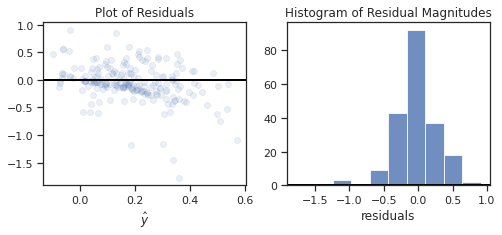

In [36]:
# Residual Plots
y_hat_train = results.predict()
residuals = y_train - y_hat_train
fig, axes = plt.subplots(1,2,figsize=(8,3))
axes[0].set_title('Plot of Residuals')
axes[0].scatter(y_hat_train, residuals, alpha=0.1)
axes[0].axhline(0, c='black', lw=2)
axes[0].set_xlabel(r'$\hat{y}$')
axes[1].set_title('Histogram of Residual Magnitudes')
axes[1].hist(residuals, alpha=0.8)
axes[1].axhline(0, c='black', lw=2)
axes[1].set_xlabel(r'residuals')
plt.show()

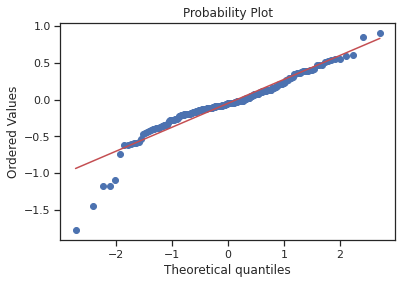

In [37]:
import pylab 
import scipy.stats as stats

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()
plt.show()

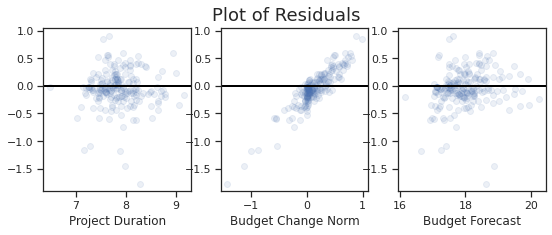

In [38]:
# Residual Plots
X_colms = ['Project Duration','Budget Change Norm','Budget Forecast']
y_hat_train = results.predict()
residuals = y_train - y_hat_train

fig, axes = plt.subplots(1,3,figsize=(9,3))
fig.suptitle('Plot of Residuals', fontsize=18)
for i in range(3):
  x_val = y_hat_train
  x_lbl = r'$\hat{y}$'
  if i > -1:
    x_val = nyc_train[X_colms[i]].ravel()
    x_lbl = X_colms[i]
  row_idx = np.mod(i,3)
  col_idx = int(i / 3) 
  axes[row_idx].scatter(x_val, residuals, alpha=0.1)
  axes[row_idx].axhline(0, c='black', lw=2)
  axes[row_idx].set_xlabel(x_lbl, fontsize=12)
plt.show()

In [39]:
X_train.iloc[:,59]

131    0
234    0
67     1
96     0
156    0
      ..
115    0
183    0
169    0
174    1
171    0
Name: Category_Water Supply, Length: 207, dtype: uint8

#### GAM Model

In [40]:
!pip install pygam
from pygam import LinearGAM, s, f
from sklearn.preprocessing import LabelEncoder

In [41]:
smoothings = np.logspace(-5, 6, 9)
cv = 10
from sklearn.model_selection import KFold
kf = KFold(n_splits=cv, random_state=42, shuffle=True)
scores = np.zeros((cv,len(smoothings)))
print(smoothings,'\n')
print(scores.shape, '\n')

[1.00000000e-05 2.37137371e-04 5.62341325e-03 1.33352143e-01
 3.16227766e+00 7.49894209e+01 1.77827941e+03 4.21696503e+04
 1.00000000e+06] 

(10, 9) 



##### Training and Test Data
Using the same training and test data as derived above.

1.   Budget Schedule Change Model: (X_train, Y_train)
2.   Schedule Change Model: (X_train2, Y_train2)

In [0]:
####  (4)  #### Handle Categorical Columns using dummy variables
#categorical_columns = ['Category', 'Borough'] # not including Agencies nor Decription
#nyc_df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)
nyc_df_gam = df.copy()

#### (5) #### Drop redundant or useless columns, and drop NaNs
drop_columns = ['Date Reported As Of', 'PID', 'Project Name', 'Description','Managing Agency', 
                'Client Agency', 'Design Start', 'Total Budget Norm', 'Latest Budget Changes', 
                'Latest Schedule Changes', 'Total Schedule Changes', 'Total Budget Changes', 
                'Forecast Completion', 'Current Phase', 'Normalized Description',
                'normal_joined']
nyc_df_gam = nyc_df_gam.drop(drop_columns, axis=1, errors='ignore')

# TRANSFORMATION
# Log of both Project Duration and Budget Forecast
nyc_df_gam['Budget Forecast'] = np.log(nyc_df_gam['Budget Forecast'])
nyc_df_gam['Project Duration'] = np.log(nyc_df_gam['Project Duration'])
nyc_df_gam = nyc_df_gam.dropna()

# Label Encoder
categorical_columns = ['Category', 'Borough']
def get_gam_x(df):
  X = df.loc[:,:]
  for name in categorical_columns:
      le =  LabelEncoder().fit(df[name].values)
      X[name] = le.transform(X[name])
  return X

nyc_df_gam = get_gam_x(nyc_df_gam)

np.random.seed(49)
nyc_train_gam, nyc_test_gam = train_test_split(nyc_df_gam, test_size=.2, random_state=49)
np.shape(nyc_df_gam)
nyc_train_g1 = nyc_train_gam.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_train_g1 = (nyc_train_g1['Budget Change Norm'])
X_train_g1 = nyc_train_g1.drop(['Budget Change Norm', 'Project Duration'], axis=1)
nyc_test_g1 = nyc_test_gam.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_test_g1 = (nyc_test_g1['Budget Change Norm'])
X_test_g1 = nyc_test_g1.drop(['Budget Change Norm', 'Project Duration'], axis=1)

In [61]:
formula = f(0) + f(1)
for i in range(2, 49, 1):
  formula += s(i)
np.random.seed(49)
X_trn, X_val, y_trn, y_val = train_test_split(X_train_g1, y_train_g1, test_size=0.2)
scores = np.zeros((len(smoothings)))
for j, smoothing in enumerate(smoothings):
    cur_model = LinearGAM(formula, lam = smoothing).fit(X_trn, y_trn)
    scores[j] = r2_score(y_val, cur_model.predict(X_val))
                              
best_lambda = smoothings[np.argmax(scores, axis = 0)]
best_lambda

3.1622776601683795

In [62]:
np.random.seed(49)
nyc_gam1 = LinearGAM(formula, lam=best_lambda).fit(X_train_g1, y_train_g1)
r_score_train = r2_score(y_train_g1, nyc_gam1.predict(X_train_g1))
r_score_test = r2_score(y_test_g1, nyc_gam1.predict(X_test_g1))


print('\n###########################################################\n')
print('\n########        Budget Change Model         #############\n')
print('\n###########################################################\n')
print('Lambda = {:0.3f}'.format(best_lambda))
print('Training R-Squared = {:0.5f}'.format(r_score_train))
print('Testing R-Squared = {:0.5f}'.format(r_score_test))
print('\n###########################################################\n')


###########################################################


########        Budget Change Model         #############


###########################################################

Lambda = 3.162
Training R-Squared = 0.20037
Testing R-Squared = 0.00435

###########################################################



In [63]:
print(nyc_gam1.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     14.2187
Link Function:                     IdentityLink Log Likelihood:                                  -249.2135
Number of Samples:                          113 AIC:                                              528.8644
                                                AICc:                                             533.9651
                                                GCV:                                                  0.17
                                                Scale:                                               0.132
                                                Pseudo R-Squared:                                   0.2004
Feature Function                  Lam

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


#### Schedule Change GAM Model

In [0]:
nyc_train_g2 = nyc_train_gam.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_train_g2 = (nyc_train_g2['Schedule Change Norm'])
X_train_g2 = nyc_train_g2.drop(['Schedule Change Norm', 'Budget Forecast'], axis=1)
nyc_test_g2 = nyc_test_gam.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_test_g2 = (nyc_test_g2['Schedule Change Norm'])
X_test_g2 = nyc_test_g2.drop(['Schedule Change Norm', 'Budget Forecast'], axis=1)

In [65]:
formula = f(0) + f(1)
for i in range(2, 49, 1):
  formula += s(i)
np.random.seed(49)
X_trn, X_val, y_trn, y_val = train_test_split(X_train_g2, y_train_g2, test_size=0.2)
scores = np.zeros((len(smoothings)))
for j, smoothing in enumerate(smoothings):
    cur_model = LinearGAM(formula, lam = smoothing).fit(X_trn, y_trn)
    scores[j] = r2_score(y_val, cur_model.predict(X_val))
                              
best_lambda2 = smoothings[np.argmax(scores, axis = 0)]
best_lambda2

3.1622776601683795

In [66]:
nyc_gam2 = LinearGAM(formula, lam=best_lambda2).fit(X_train_g2, y_train_g2)
r_score_train = r2_score(y_train_g2, nyc_gam2.predict(X_train_g2))
r_score_test = r2_score(y_test_g2, nyc_gam2.predict(X_test_g2))


print('\n###########################################################\n')
print('\n########        Schedule Change Model         #############\n')
print('\n###########################################################\n')
print('Lambda = {:0.3f}'.format(best_lambda))
print('Training R-Squared = {:0.5f}'.format(r_score_train))
print('Testing R-Squared = {:0.5f}'.format(r_score_test))
print('\n###########################################################\n')


###########################################################


########        Schedule Change Model         #############


###########################################################

Lambda = 3.162
Training R-Squared = 0.25619
Testing R-Squared = 0.06092

###########################################################



In [67]:
print(nyc_gam2.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     14.1841
Link Function:                     IdentityLink Log Likelihood:                                  -883.6047
Number of Samples:                          113 AIC:                                             1797.5776
                                                AICc:                                            1802.6541
                                                GCV:                                                0.0561
                                                Scale:                                              0.0436
                                                Pseudo R-Squared:                                   0.2562
Feature Function                  Lam

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


## Neural Network

In [0]:
%tensorflow_version 2.0.0

In [71]:
!pip install tensorflow==2.0.0
!pip install tf_keras_vis
#Getting all pip packages
import subprocess
import sys
reqs = subprocess.check_output([sys.executable, '-m', 'pip', 'freeze'])
installed_packages = [r.decode().split('==') for r in reqs.split()]
#installing tensorflow-datasets==2.1.0
if ['tensorflow-datasets', '2.1.0'] not in installed_packages:
  !pip uninstall tensorflow-datasets -y
  !pip install tensorflow-datasets==2.1.0 
#installing tensorflow-addons==0.6.0
if ['tensorflow-addons', '0.6.0'] not in installed_packages:
  !pip uninstall tensorflow-addons -y
  !pip install tensorflow-addons==0.6.0

In [0]:

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras.metrics import *

from tensorflow.keras import Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Reshape, Concatenate, Lambda
from tensorflow.keras.optimizers import Adam, SGD

#### Budget Change Model

In [82]:
input = Input(shape=(49,))
input_1 = Lambda(lambda x: x[:, 0:4])(input)
input_2 = Lambda(lambda x: x[:, 4:49])(input)
dense1 = Dense(7, name='description', activation='linear')(input_2)
dense2 = Dense(2, activation='linear')(input_1)
conc1 = Concatenate(axis = 1)([dense1, dense2])
output = Dense(1, activation='linear')(conc1)
model = tf.keras.Model(input, output)
model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 49)]         0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 45)           0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4)            0           input_2[0][0]                    
__________________________________________________________________________________________________
description (Dense)             (None, 7)            322         lambda_3[0][0]                   
____________________________________________________________________________________________

In [0]:
np.random.seed(49)
nyc_train_gam, nyc_test_gam = train_test_split(nyc_df_gam, test_size=.1, random_state=49)
np.shape(nyc_df_gam)
nyc_train_nn1 = nyc_train_gam.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_train_nn1 = (nyc_train_nn1['Budget Change Norm'])
X_train_nn1 = nyc_train_nn1.drop(['Budget Change Norm', 'Project Duration'], axis=1)
nyc_test_nn1 = nyc_test_gam.copy()
#nyc_train_trunc = nyc_train_trunc[qual_columns]
y_test_nn1 = (nyc_test_nn1['Budget Change Norm'])
X_test_nn1 = nyc_test_nn1.drop(['Budget Change Norm', 'Project Duration'], axis=1)

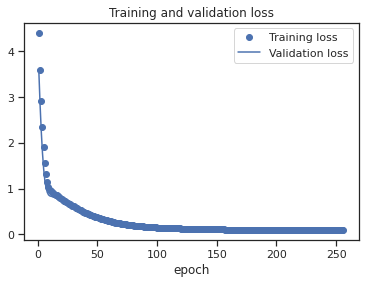

Final Training Loss: 0.08473625847387432
Final Validation Loss: 0.1130680963397026


In [84]:
history = model.fit(X_train_nn1.values, y_train_nn1.values, epochs=256, batch_size=32, verbose=False, shuffle=True, validation_split=0.2)
def plot_training_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)

    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    print(f'Final Training Loss: {final_train_loss}')
    print(f'Final Validation Loss: {final_val_loss}')
plot_training_history(history)

In [85]:
score, _ = model.evaluate(X_test_nn1.values, y_test_nn1.values,batch_size=32)
print('Test score:', score)

15/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 369us/sample - loss: 0.1515 - accuracy: 0.0000e+00
Test score: 0.15153376758098602


#### Schedule Change Model

In [89]:
model2 = tf.keras.models.clone_model(model)
model2.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 49)]         0                                            
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 45)           0           input_2[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4)            0           input_2[0][0]                    
__________________________________________________________________________________________________
description (Dense)             (None, 7)            322         lambda_3[0][0]                   
____________________________________________________________________________________________

In [0]:
nyc_train_nn2 = nyc_train_gam.copy()
y_train_nn2 = (nyc_train_nn2['Schedule Change Norm'])
X_train_nn2 = nyc_train_nn2.drop(['Schedule Change Norm', 'Budget Forecast'], axis=1)
nyc_test_nn2 = nyc_test_gam.copy()
y_test_nn2 = (nyc_test_nn2['Schedule Change Norm'])
X_test_nn2 = nyc_test_nn2.drop(['Schedule Change Norm', 'Budget Forecast'], axis=1)

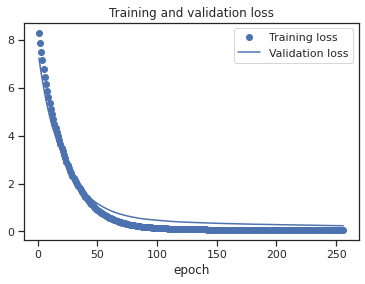

Final Training Loss: 0.04369113727076219
Final Validation Loss: 0.23951806128025055


In [90]:
history2 = model2.fit(X_train_nn2.values, y_train_nn2.values, epochs=256, batch_size=32, verbose=False, shuffle=True, validation_split=0.2)
plot_training_history(history2)

In [91]:
score, _ = model2.evaluate(X_test_nn2.values, y_test_nn2.values,batch_size=32)
print('Test score:', score)

15/1 [==================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 247us/sample - loss: 0.0832 - accuracy: 0.0667
Test score: 0.0831717997789383
